<a href="https://colab.research.google.com/github/LolaSM/neck-pain/blob/main/speed_acceleration/classification_models_neck_pain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load and Visualization of Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
url ='https://github.com/LolaSM/neck-pain/blob/main/speed_acceleration/tablaVectores_AB_speed_acceleration.csv'
patients_vector = pd.read_csv(url)

Each group (A:pain-free (0), B:pain-affected (1)) will be represented by an integer

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
patients_vector['group'] = le.fit_transform(patients_vector['group'])

Quick info and distribution

In [ ]:
print(patients_vector.info())
print(patients_vector['group'].value_counts())
print(patients_vector.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patient    87 non-null     int64  
 1   group      87 non-null     int64  
 2   mediaVelX  87 non-null     float64
 3   mediaVelY  87 non-null     float64
 4   mediaVelZ  87 non-null     float64
 5   mediaAccX  87 non-null     float64
 6   mediaAccY  87 non-null     float64
 7   mediaAccZ  87 non-null     float64
 8   stdVelX    87 non-null     float64
 9   stdVelY    87 non-null     float64
 10  stdVelZ    87 non-null     float64
 11  stdAccX    87 non-null     float64
 12  stdAccY    87 non-null     float64
 13  stdAccZ    87 non-null     float64
 14  kurVelX    87 non-null     float64
 15  kurVelY    87 non-null     float64
 16  kurVelZ    87 non-null     float64
 17  kurAccX    87 non-null     float64
 18  kurAccY    87 non-null     float64
 19  kurAccZ    87 non-null     float64
 20  skwVelX    8

Distribution of the features according to the group

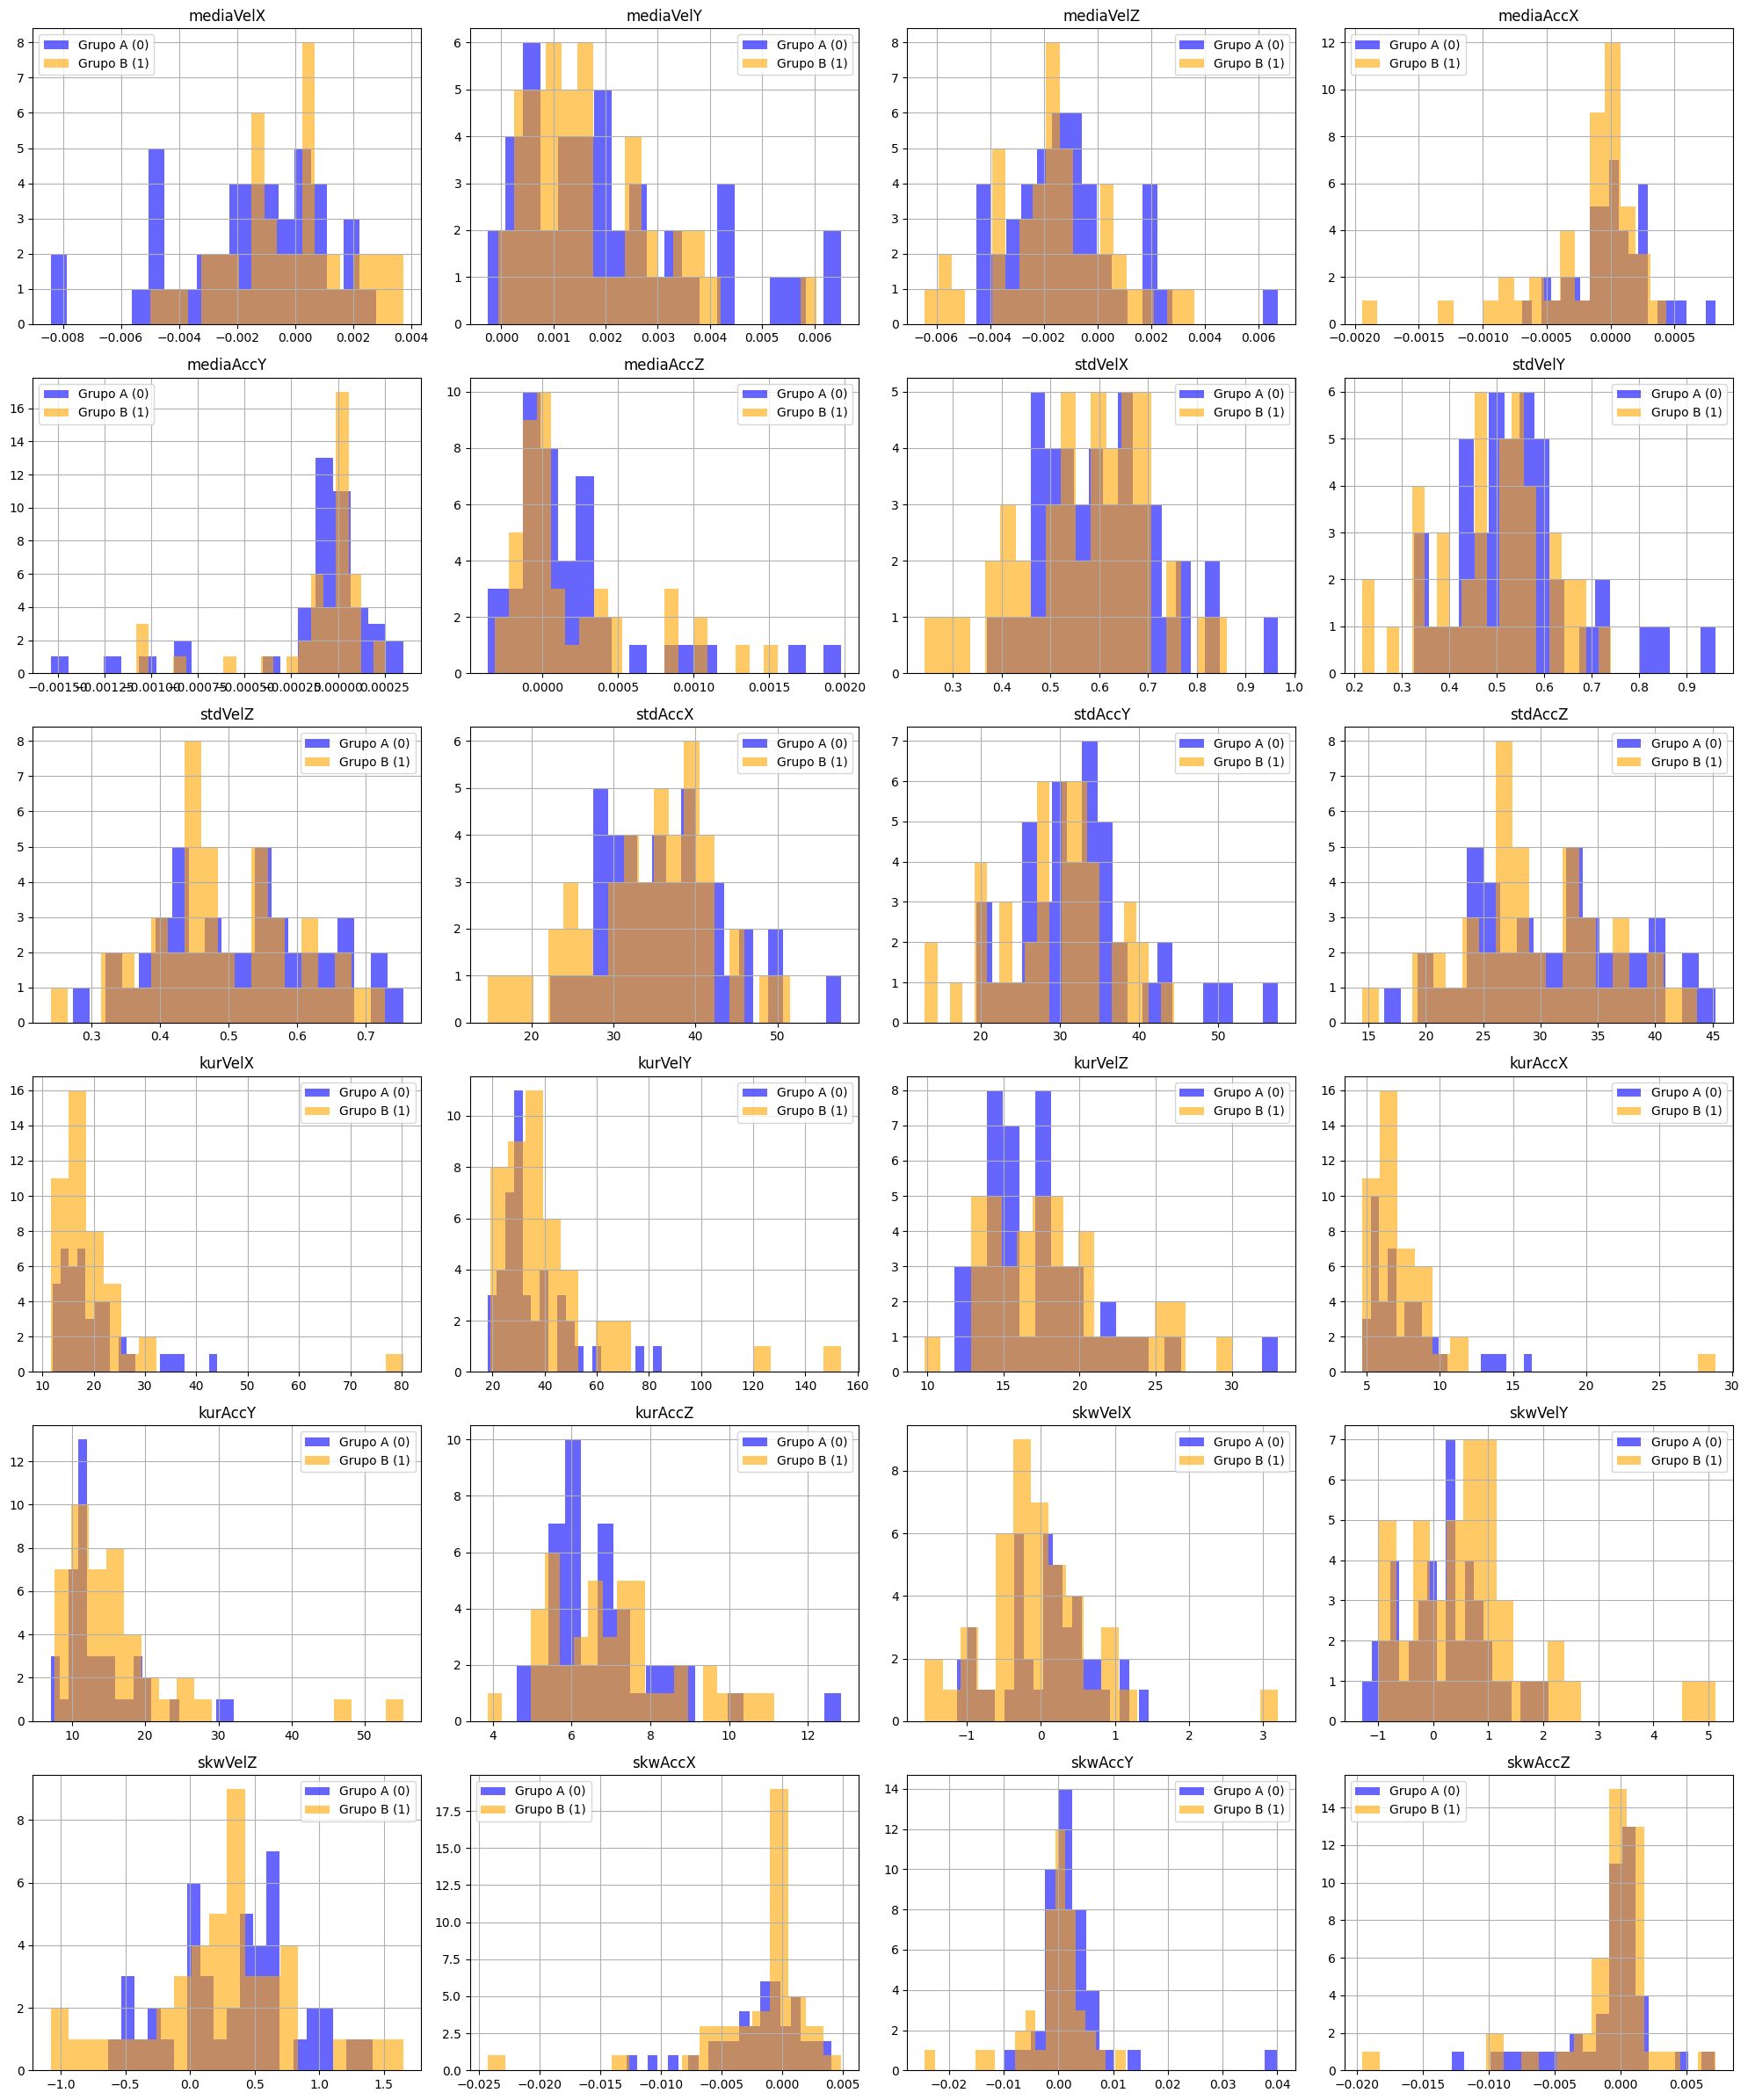

In [ ]:
import matplotlib.pyplot as plt

# Filtra los grupos
grupo_a = patients_vector[patients_vector["group"] == 0]
grupo_b = patients_vector[patients_vector["group"] == 1]

# Lista de características (sin 'patient' ni 'group')
features = patients_vector.drop(columns=["patient", "group"]).columns

# Tamaño del gráfico
n_cols = 4
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

# Aplanar axes en caso de que sea 2D
axes = axes.flatten()

# Generar histogramas superpuestos
for i, feature in enumerate(features):
    ax = axes[i]
    grupo_a[feature].hist(ax=ax, bins=20, alpha=0.6, color="blue", label="Grupo A (0)")
    grupo_b[feature].hist(ax=ax, bins=20, alpha=0.6, color="orange", label="Grupo B (1)")
    ax.set_title(feature)
    ax.legend()

# Quitar subplots vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Exploring Correlation

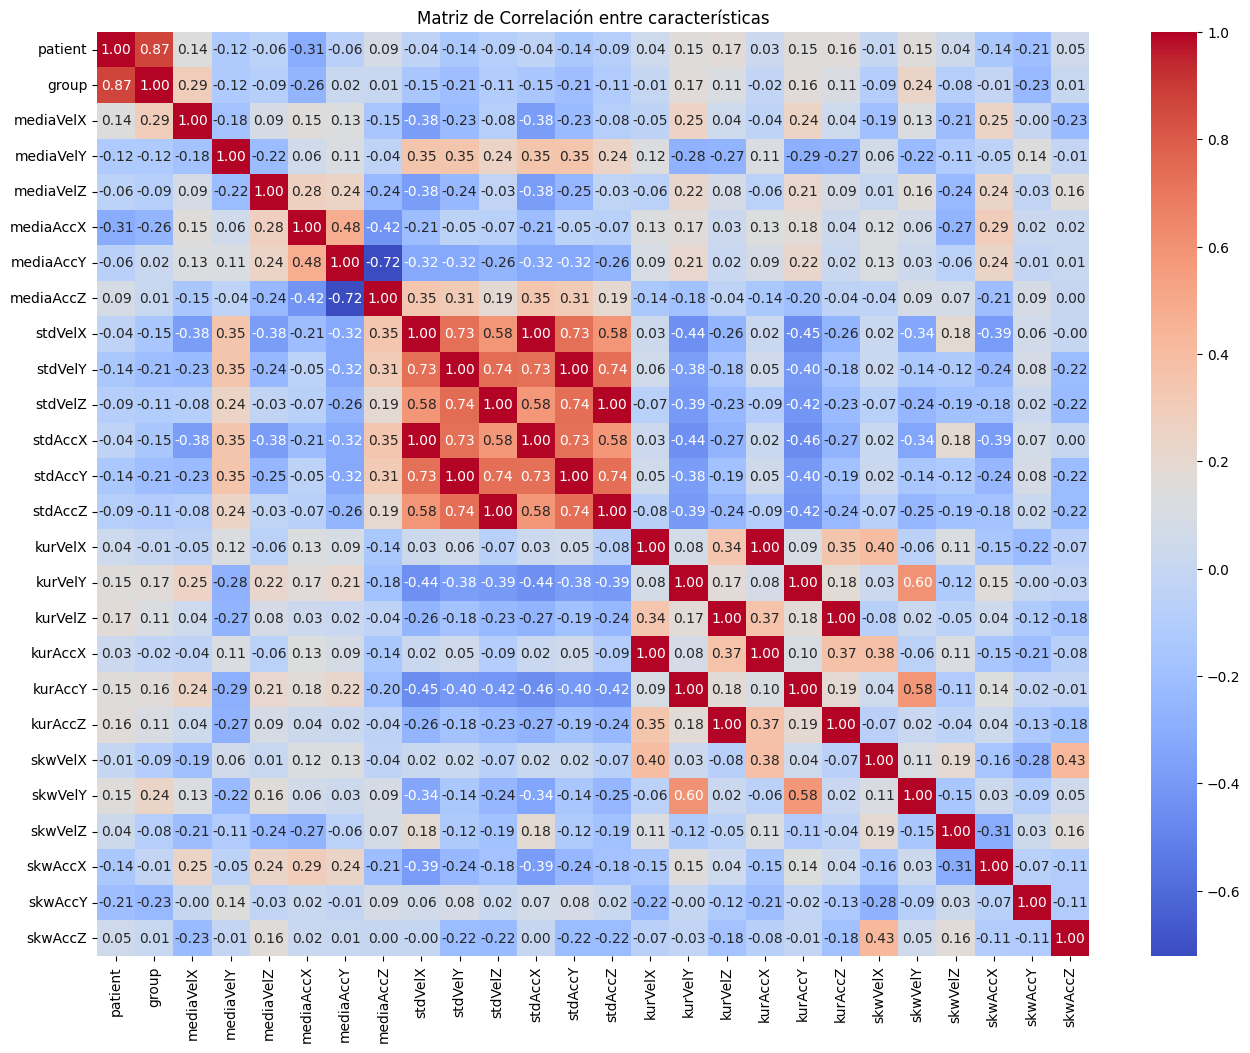

In [ ]:
corr_matrix = patients_vector.corr()
import seaborn as sns
# Dibujar el heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación entre características")
plt.show()

Most correlated features:
- KurAcc - KurVel
- StdAcc - StdVel

##Preprocessing and Splitting Data

Division of the dataset into:

*   80% training
*   10% validation
*   10% test

Stratified sampling to produce sets that contain a representative ratio of each class.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop identifier
df = patients_vector.drop(columns=["patient"])
X = df.drop("group", axis=1)
y = df["group"]

# Split: 80% Train, 10% Validation, 10% Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)

print(f"Size of training set: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Size of validation set: {X_val.shape[0]} ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Size of test set: {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")


#no need for scaling in decision trees

Size of training set: 69 (79.3%)
Size of validation set: 9 (10.3%)
Size of test set: 9 (10.3%)


## Classification Algorithms

The concatenation of training set and validation set (90%) of the data used for training has proven better results

In [ ]:
X_search = pd.concat([X_train, X_val])
y_search = pd.concat([y_train, y_val])

##Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search_rf.fit(X_search, y_search)

# Best model
best_rf = grid_search_rf.best_estimator_
best_score = grid_search_rf.best_score_
std_score = grid_search_rf.cv_results_['std_test_score'][grid_search_rf.best_index_]
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print(f"Cross-validation accuracy: {best_score:.3f} ± {std_score:.3f}")

# Evaluation on test set
y_pred_rf = best_rf.predict(X_test)

print("\nRandom Forest - Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-validation accuracy: 0.501 ± 0.096

Random Forest - Test Accuracy: 0.5555555555555556
Confusion Matrix:
 [[3 1]
 [3 2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.67      0.40      0.50         5

    accuracy                           0.56         9
   macro avg       0.58      0.57      0.55         9
weighted avg       0.59      0.56      0.54         9



Analysis of the importance of the features

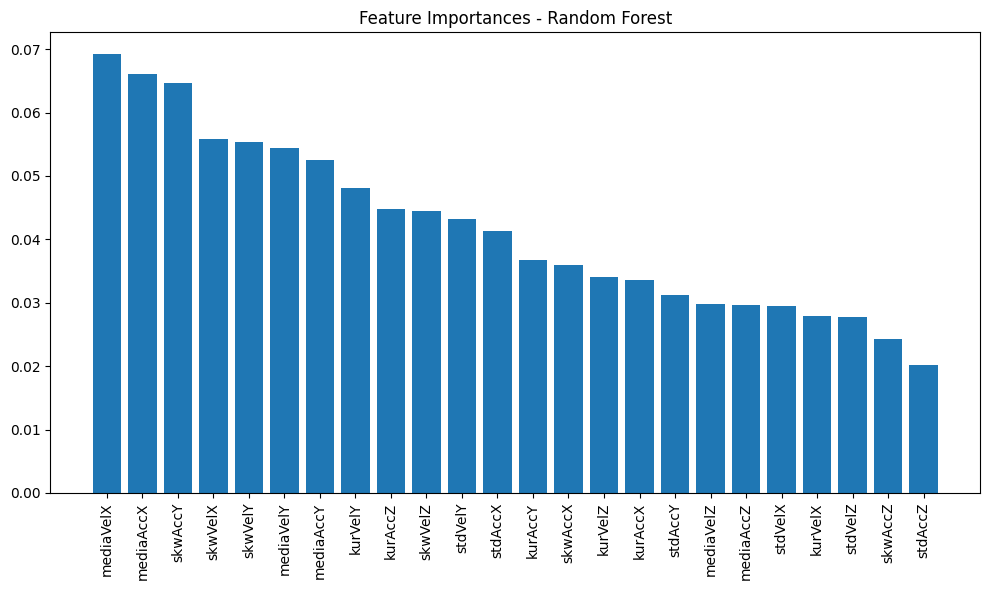

In [ ]:
# Feature Importances
importances = best_rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

##Multilayer perceptron (MLP) for classification

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define MLP pipeline with scaling
mlp_pipeline = make_pipeline(
    StandardScaler(),
    MLPClassifier(max_iter=1000, random_state=42)
)

# Grid of hyperparameters
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(30,), (50,), (50, 30), (50, 50)],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],
    'mlpclassifier__learning_rate': ['constant', 'adaptive']
}

# Grid search with cross-validation (5-fold)
grid_search_mlp = GridSearchCV(
    mlp_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search_mlp.fit(X_search, y_search)

# Best model
best_mlp = grid_search_mlp.best_estimator_
best_score = grid_search_mlp.best_score_
std_score = grid_search_mlp.cv_results_['std_test_score'][grid_search_mlp.best_index_]
print("Best parameters:", grid_search_mlp.best_params_)
print(f"Cross-validation accuracy: {best_score:.3f} ± {std_score:.3f}")

# Evaluate on test set
y_pred_mlp = best_mlp.predict(X_test)

print("\n MLP - Test Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))


Best parameters: {'mlpclassifier__alpha': 0.0001, 'mlpclassifier__hidden_layer_sizes': (50, 50), 'mlpclassifier__learning_rate': 'constant'}
Cross-validation accuracy: 0.513 ± 0.082

 MLP - Test Accuracy: 0.8888888888888888
Confusion Matrix:
 [[3 1]
 [0 5]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.83      1.00      0.91         5

    accuracy                           0.89         9
   macro avg       0.92      0.88      0.88         9
weighted avg       0.91      0.89      0.89         9



## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define pipeline with scaling + logistic regression
logreg_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)

# Grid of hyperparameters
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength (inverse)
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs', 'liblinear']
}

# Grid search with 5-fold cross-validation
grid_search_lr = GridSearchCV(
    logreg_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search_lr.fit(X_train, y_train)

# Best model
best_lr = grid_search_lr.best_estimator_
best_score = grid_search_lr.best_score_
std_score = grid_search_lr.cv_results_['std_test_score'][grid_search_lr.best_index_]
print("Best parameters:", grid_search_lr.best_params_)
print(f"Cross-validation accuracy: {best_score:.3f} ± {std_score:.3f}")



# Evaluate on test set
y_pred_lr = best_lr.predict(X_test)

print("\n Logistic Regression - Test Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Best parameters: {'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Cross-validation accuracy: 0.668 ± 0.104

 Logistic Regression - Test Accuracy: 0.7777777777777778
Confusion Matrix:
 [[2 2]
 [0 5]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.71      1.00      0.83         5

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9



## Support Vector Machine Classifier(SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Define SVM pipeline with scaling
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', probability=True, random_state=42)  # You can change kernel to 'linear' or 'poly' if needed
)

# Hyperparameter grid for SVM
param_grid_svm = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf', 'linear']
}

# Grid search with 5-fold CV
grid_search_svm = GridSearchCV(
    svm_pipeline,
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit grid search
grid_search_svm.fit(X_search, y_search)

# Best model
best_svm = grid_search_svm.best_estimator_
best_score = grid_search_svm.best_score_
std_score = grid_search_svm.cv_results_['std_test_score'][grid_search_svm.best_index_]
print("Best parameters for SVM:", grid_search_svm.best_params_)
print(f"Cross-validation accuracy: {best_score:.3f} ± {std_score:.3f}")

# Evaluate on test set
y_pred_svm = best_svm.predict(X_test)

print("\n SVM - Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


Best parameters for SVM: {'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Cross-validation accuracy: 0.617 ± 0.063

 SVM - Test Accuracy: 0.7777777777777778
Confusion Matrix:
 [[3 1]
 [1 4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.80      0.80      0.80         5

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9

